In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [4]:
train_transaction=pd.read_csv('/Users/mac/Desktop/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/Users/mac/Desktop/ieee-fraud-detection/train_identity.csv')

In [5]:
train=train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)

In [6]:
raw=train.copy()

In [7]:
raw.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
mis=raw.isna().sum()

In [9]:
raw['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [10]:
for item in train.columns:
    if train[item].dtype==object:
        if mis[item]<10000:
            train[item].fillna(train[item].mode().iloc[0],inplace=True)
        else:
            train[item].fillna('missing',inplace = True)
            
    else:
        train[item].fillna(train[item].mode().iloc[0], inplace=True)

In [11]:
len(raw.columns[mis>400000])

209

In [12]:
train.drop(raw.columns[mis>400000],axis=1,inplace=True)  #delete columns that have missing value over 400000

In [13]:
#one hot encoding
for i in train.columns:
    if train[i].dtype=='object':
        dummies=pd.get_dummies(train[i])
        dummies=dummies.add_prefix("{}#".format(i))
        train.drop(i,axis=1,inplace=True)
        train=train.join(dummies)

In [14]:
train.shape

(590540, 314)

In [15]:
train.columns

Index(['TransactionID_x', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'M6#missing', 'M7#F', 'M7#T', 'M7#missing', 'M8#F', 'M8#T',
       'M8#missing', 'M9#F', 'M9#T', 'M9#missing'],
      dtype='object', length=314)

In [16]:
train_sample= train.groupby('isFraud').apply(lambda x: x.sample(frac=0.3))  #Take a sample

In [17]:
train_sample['isFraud'].value_counts() #Same proportion as original set

0    170963
1      6199
Name: isFraud, dtype: int64

In [18]:
y=train_sample['isFraud']
X=train_sample.drop(['isFraud','TransactionID_x'],axis=1)

In [19]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y,random_state=42)

In [20]:
sc = StandardScaler() #feature scaling
  
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
pca = PCA(n_components = 100)  #pca
  
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test) 

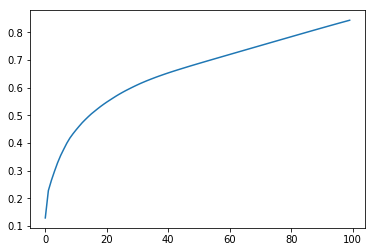

In [22]:
_=plt.plot(np.cumsum(pca.explained_variance_ratio_)) #first 100 PCs explain 80% of total variance

In [23]:
#SMOTE
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

In [24]:
os_data_X.shape

(256444, 100)

In [ ]:
#import time
# defining parameter range 
#param_grid = {'C': [0.1, 1, 10, 100, 1000],  
#              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
#              'kernel': ['rbf']}  
  
#grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
#grid.fit(X_train, y_train) 
#print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#print(grid.best_params_)
#print(grid.best_estimator_)

In [ ]:
#grid_predictions = grid.predict(X_test) 

In [25]:
import time
start_time = time.time()
svclassifier = SVC(kernel='rbf')
svclassifier.fit(os_data_X, os_data_y)
print("--- %s seconds ---" % (time.time() - start_time))

/Users/mac/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


--- 5627.6528441905975 seconds ---


In [26]:
#predict
y_pred_svm = svclassifier.predict(X_test)

In [27]:
#auc
svm_roc_auc = roc_auc_score(y_test, y_pred_svm)
print(svm_roc_auc)

0.757680273756935


In [35]:
print("Area under the ROC curve is 0.757680273756935")
print("F1-score is {}".format(f1_score(y_test, y_pred_svm, average="macro")))
print("Precision is {}".format(precision_score(y_test, y_pred_svm, average="macro")))
print("Recall is {}".format(recall_score(y_test, y_pred_svm, average="macro")))

Area under the ROC curve is 0.757680273756935
F1-score is 0.627555802672971
Precision is 0.5949812275845299
Recall is 0.757680273756935


In [29]:
#fpr & tpr
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)

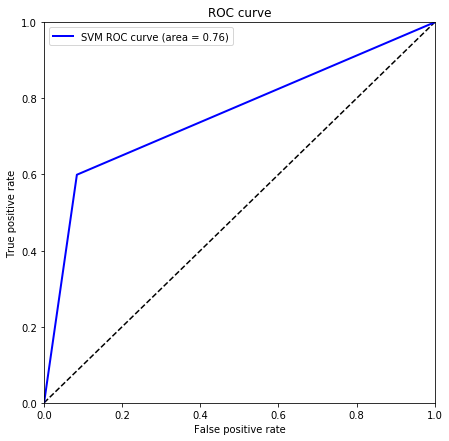

In [30]:
#plot roc curve
plt.subplots(figsize=(7, 7))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_svm, tpr_svm,color = 'blue',label = 'SVM ROC curve (area = {0:0.2f})'
               ''.format(svm_roc_auc),lw=2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
_=plt.legend(loc='best',fontsize=10)